In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import numpy as np
import six
import tensorflow as tf

from edward.inferences import VariationalInference
from edward.models import Bernoulli, Normal, RandomVariable
from edward.util import copy
from scipy.special import expit
from sklearn.metrics import log_loss

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


ed.set_seed(42)

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import pylab
pylab.rcParams['figure.figsize'] = (16.0, 10.0)

# use custom helper functions from src folder
import sys
sys.path.insert(0, '../src/')

from data import *
from inference import *
from helpers import *
from model_zoo import conv_lstm 

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


### DATA

In [2]:
# # for this basic example, lets only examine a small subset of the data
# %pdb on
# N = 10000  # number of data points
# D = 50  # number of features
# X_data, y_data, X_test, y_test = get_dataset(N=N,D=D, make_balanced=True)
# print('shapes (X,y),', X_data.shape, y_data.shape)

In [3]:
#new dataset with pca
from dataset import *
pca_comps = range(0,50)
dataset = DataSet(pca_comps=pca_comps, frac=1)
X_data, y_data, X_test, y_test = dataset.get_train_and_val()
print('shapes (X_data,y_data),', X_data.shape, y_data.shape)
print('dataset is balanced: y.mean =', y_data.mean())

Shapes:
X_train: (24996, 50)
training_data (25001, 53)
Index(['id', 'era', 'target', 'feature_prepro_0', 'feature_prepro_1',
       'feature_prepro_2', 'feature_prepro_3', 'feature_prepro_4',
       'feature_prepro_5', 'feature_prepro_6', 'feature_prepro_7',
       'feature_prepro_8', 'feature_prepro_9', 'feature_prepro_10',
       'feature_prepro_11', 'feature_prepro_12', 'feature_prepro_13',
       'feature_prepro_14', 'feature_prepro_15', 'feature_prepro_16',
       'feature_prepro_17', 'feature_prepro_18', 'feature_prepro_19',
       'feature_prepro_20', 'feature_prepro_21', 'feature_prepro_22',
       'feature_prepro_23', 'feature_prepro_24', 'feature_prepro_25',
       'feature_prepro_26', 'feature_prepro_27', 'feature_prepro_28',
       'feature_prepro_29', 'feature_prepro_30', 'feature_prepro_31',
       'feature_prepro_32', 'feature_prepro_33', 'feature_prepro_34',
       'feature_prepro_35', 'feature_prepro_36', 'feature_prepro_37',
       'feature_prepro_38', 'feature_prepro

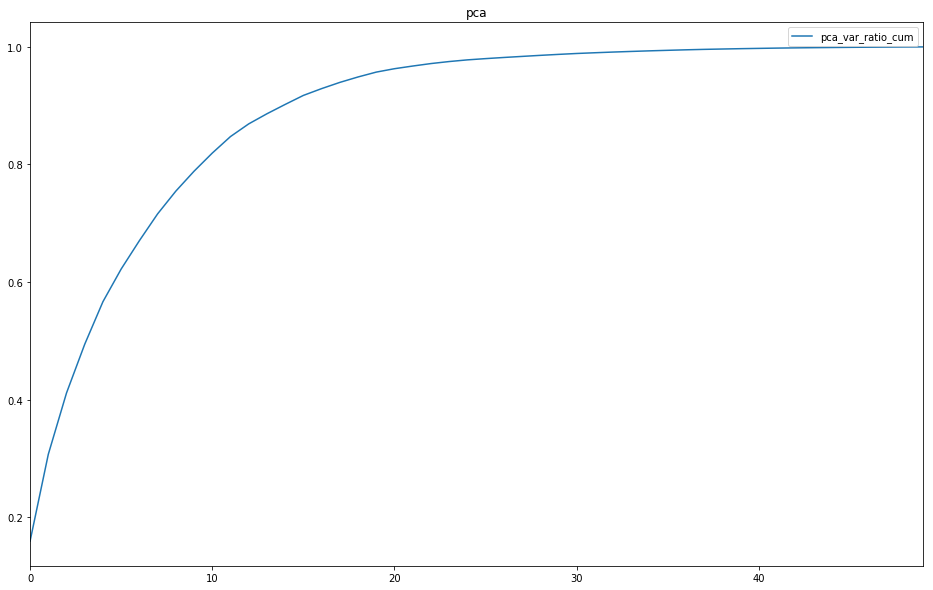

In [4]:
pca_cum_var_expl = pd.DataFrame({'pca_var_ratio_cum':dataset.pca.explained_variance_ratio_}).cumsum()
ax = pca_cum_var_expl.plot(title='pca')
# xypt = (9, np.round(pca_cum_var_expl.loc[pca_comps].values[9][0],2))
# ax.axvline(xypt[0], color='k', linestyle='--')
# ax.axhline(xypt[1], color='k', linestyle='--')
# ax.annotate(xypt, xy=xypt,
#             arrowprops=dict(facecolor='black'),
#             )
# ax.plot(pca_comps, pca_cum_var_expl.values[0:10,0]);

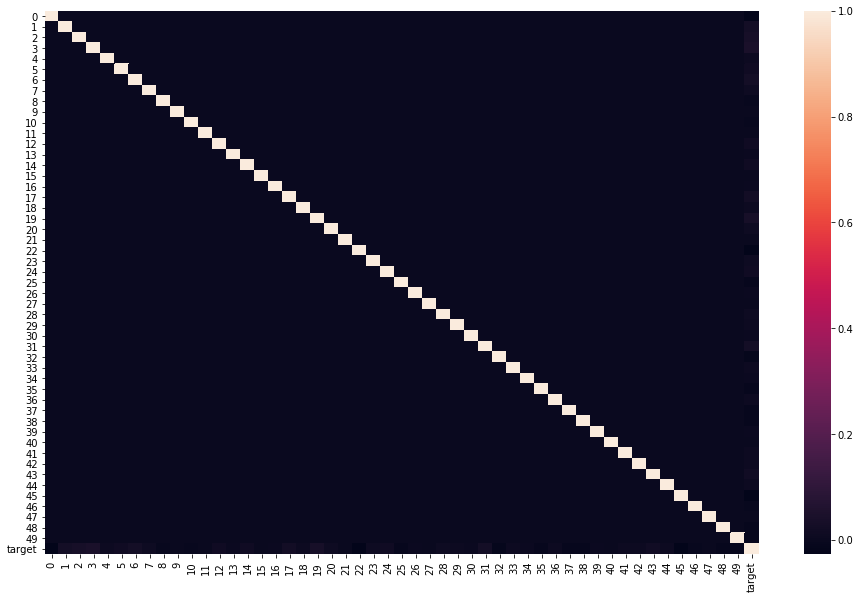

In [42]:
df = pd.DataFrame(X_data)
df['target'] = y_data
sns.heatmap(df.corr());
# title='correlation of features and binary target'

In [48]:
abs(df.corr()['target']).sort_values(ascending=False).head(10)

target    1.000000
3         0.042838
19        0.036659
2         0.035413
6         0.028047
1         0.027553
0         0.027338
22        0.025611
31        0.025386
45        0.023501
Name: target, dtype: float64

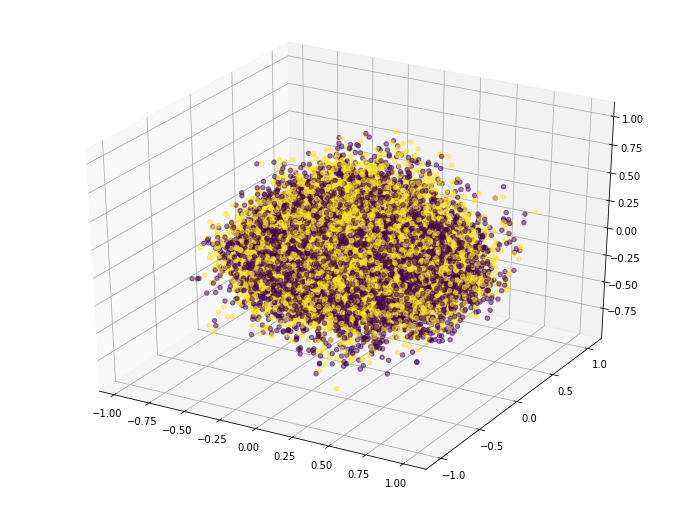

In [6]:
fig = plt.figure(figsize=(12, 9))
ax = plt.axes(projection='3d')
ax.scatter(X_data[:, 0], X_data[:, 1], X_data[:,2], c=y_data, alpha=.5);

In [7]:
M = 128    # batch size during training
y_ph = tf.placeholder(tf.int32, [None])
data = generator([X_data, y_data], M)    

In [8]:
D = X_data.shape[1]

### MODEL

In [9]:
# from edward.models import Bernoulli, Normal
# from tensorflow.contrib import slim

# z = Normal(loc=tf.zeros([N, d]), scale=tf.ones([N, d]))
# h = slim.fully_connected(z, 256)
# y = Bernoulli(logits=slim.fully_connected(h, 28 * 28, activation_fn=None))

In [10]:
from edward.models import *

X = tf.placeholder(tf.float32, [None , D])
w = Normal(loc=tf.zeros(D), scale=tf.ones(D)*10)
b = Normal(loc=tf.zeros(1), scale=tf.ones(1)*10)
y = Bernoulli(logits=(ed.dot(X, w)+b))

### INFERENCE

In [11]:
qw = Normal(loc=tf.Variable(tf.random_normal([D])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([D]))))
qb = Normal(loc=tf.Variable(tf.random_normal([1])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

Helper functions to maximize the Evidence Lower bound (moved "log" outside compared to standard VAE)

$$ log(p(x)) >= -E_{q(z^1; \lambda), ..., q(z^K; \lambda)} [ \log \frac{1}{K} \sum_{k=1}^K \frac{p(x, z^k)}{q(z^k; \lambda)} ]$$

In [12]:
# inference = IWVI({w: qw,  b: qb}, data={X: X_data, y: y_data})
# inference.run(K=5, n_iter=100, n_print=1)

Alternatively, we use KLqp for the sake of batch learning

384/384 [100%] ██████████████████████████████ Elapsed: 12s | Loss: 17166.898


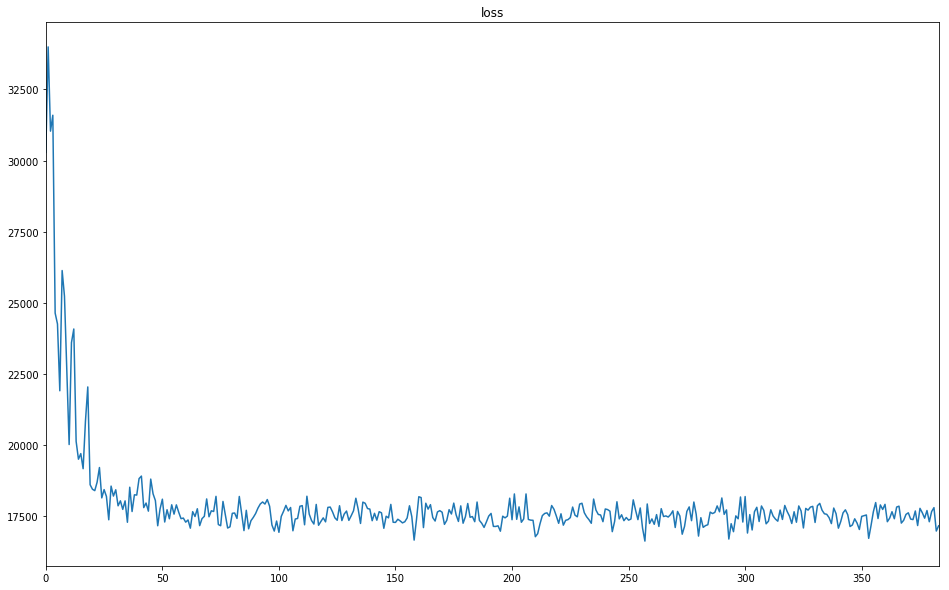

In [13]:
N = len(X_data)
n_batch = M
n_epoch = 3

inference = ed.KLqp({w: qw, b: qb}, data={y: y_ph})
inference.initialize(n_iter=n_batch * n_epoch, n_samples=5, scale={y: N / M}, logdir='../log')
tf.global_variables_initializer().run()

info_dicts = []
for _ in range(inference.n_iter):
  X_batch, y_batch = next(data)
  info_dict = inference.update({X: X_batch, y_ph: y_batch})
  inference.print_progress(info_dict)
  info_dicts.append(info_dict)
pd.Series([x['loss'] for x in info_dicts]).plot(title='loss');

### CRITICISM

In [14]:
y_post = ed.copy(y, {w: qw, b:qb})

#### todo: implemention of edward's logloss metric is buggy as it accepts predictions instead of logits
#### I've raised an issue here: https://github.com/blei-lab/edward/issues/795

In [15]:
for sam,Xx,yy in [("INS", X_data, y_data), ("OOS",X_test, y_test)]:
    print(sam)
    print("binary_acc:", ed.evaluate('binary_accuracy', data={X: Xx, y_post: yy}))
    print("binary_cross_entropy:", ed.evaluate('log_loss', data={X: Xx, y_post: yy}))  # todo bug in implementation

INS
binary_acc: 0.534486
binary_cross_entropy: 0.734471
OOS
binary_acc: 0.518048
binary_cross_entropy: 0.744802


In [16]:
print("log_loss:", ed.evaluate('log_loss', data={X: X_data, y_post: y_data})) # todo bug in implementation
print("categorical_crossentropy:", ed.evaluate('categorical_crossentropy', data={X: X_data, y_post: y_data}))
print("log_likelihood:", ed.evaluate('log_likelihood', data={X: X_data, y_post: y_data}))

log_loss: 0.734685
categorical_crossentropy: 127637.0
log_likelihood: -0.689929


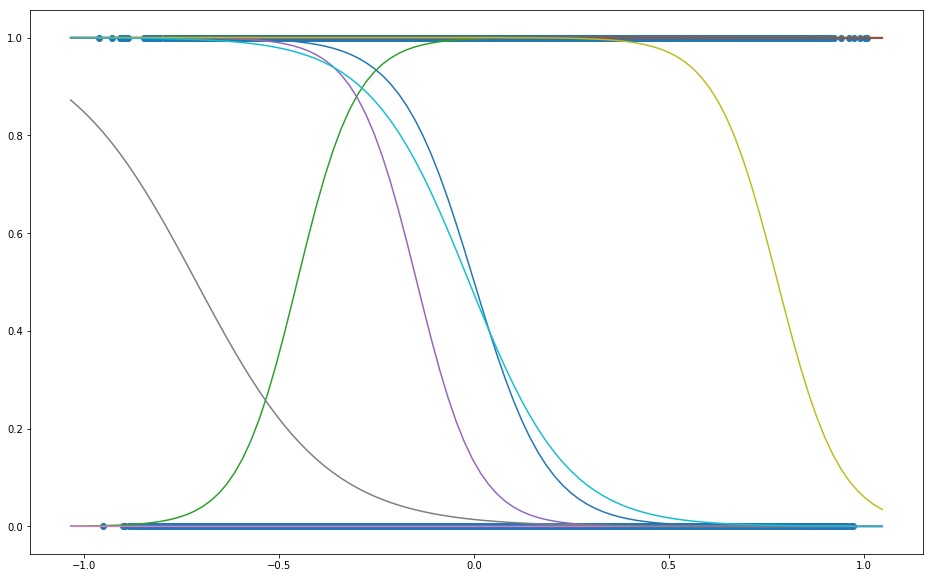

In [17]:
ww = visualise(X_data, y_data, w, b) #prior samples

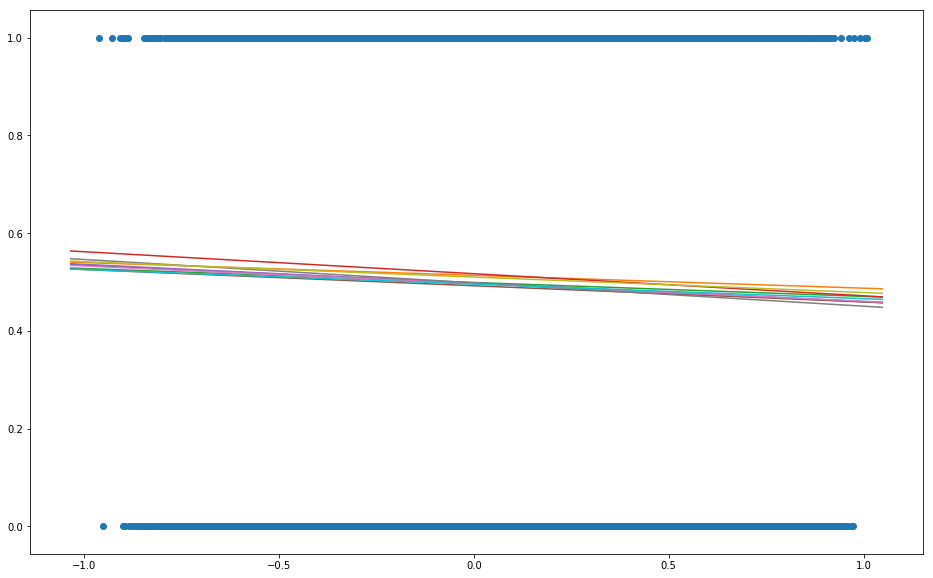

In [18]:
ww = visualise(X_data, y_data, qw, qb) #posterior samples

In [19]:
def binary_crossentropy(y_true, y_pred):
  """Binary cross-entropy.
  Args:
    y_ue: tf.Tensor.
      Tensor of 0s and 1s.
    y_pred: tf.Tensor.
      Tensor of real values (logit probabilities), with same shape as
      `y_true`.
  """
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.cast(y_pred, tf.float32)
  return tf.reduce_mean(
      tf.nn.sigmoid_cross_entropy_with_logits(logits=y_pred, labels=y_true))

In [20]:
from edward.util import check_data, get_session
from sklearn.metrics import log_loss

def get_y_preds(X_data, y_data, w, b, n_samples=10):
    w_samples = [w.eval() for _ in range(n_samples)]
    b_samples = [b.eval() for _ in range(n_samples)]
    return w_samples, b_samples

def eval_model(Xx, Yy, nom, probabilities=None):
    if probabilities is None:
        ans = get_y_preds(Xx, Yy, qw, qb, n_samples=10000)
        zw, zb = np.mean(ans[0], axis=0), np.mean(ans[1], axis=0)
        probabilities = sigmoid(Xx.dot(zw) + zb)
        #probabilities = probabilities.clip(.49,.51)
        
    ins = pd.DataFrame(probabilities, columns=['prob'])
    ins['target'] = Yy
    ins['guess'] = ins['prob'].round().clip(0,1)
    print(nom, '\n------')
    print('acc:', (ins['target'] == ins['guess']).mean())
    print('sk.logloss:', log_loss(ins['target'], ins['prob']))
    sess = get_session()
    print('ed.logloss (corrected):', sess.run(binary_crossentropy(ins['target'], -np.log(1/ins['prob'] -1)   )   ))
    print('ed.logloss (current):', sess.run(binary_crossentropy(ins['target'], ins['prob']   )   ))

    if nom=='ins':
        eras = dataset.training_data['era']
    else:
        eras = dataset.prediction_data['era']
        
    big_ins = pd.concat([pd.DataFrame(Xx), eras, ins], axis=1).dropna()
    consist=0
    for x in big_ins.era.unique():
        lil_ins = big_ins[big_ins.era==x]
        lloss = log_loss(lil_ins['target'], lil_ins['prob'])
        print(x.replace("era","regime"),
              '(%s) :' % str(float(len(lil_ins))/len(big_ins))[:5],
              (lil_ins['target'] == lil_ins['guess']).mean(),
              lloss)
        if lloss < -np.log(.5):
            consist+=1
            
    print('consistency:', float(consist)/len(big_ins.era.unique()))
    print ('')
    return ins

ins = eval_model(X_data, y_data, 'ins')
oos = eval_model(X_test, y_test, 'oos');

ins 
------
acc: 0.534205472876
sk.logloss: 0.688725881075
ed.logloss (corrected): 0.688727
ed.logloss (current): 0.721786
regime1 (0.253) : 0.523967202775 0.690572948717
regime2 (0.252) : 0.540570522979 0.688591725638
regime3 (0.251) : 0.52092283214 0.691211357781
regime4 (0.242) : 0.552031714569 0.684373002291
consistency: 1.0

oos 
------
acc: 0.517548245175
sk.logloss: 0.694225062376
ed.logloss (corrected): 0.694225
ed.logloss (current): 0.722627
regime86 (0.609) : 0.514529633886 0.695347738816
regime87 (0.390) : 0.522250639386 0.692476156444
consistency: 0.5



In [21]:
# see how eval metrics look under sample of maximum uncertainy

from edward.util import check_data, get_session
from sklearn.metrics import log_loss

preds = np.array([.5]*1000)
target = np.random.randint(0,2,1000)

print('acc:', (target == preds.round()).mean())
print('logloss:', log_loss(target, preds))
sess = get_session()
print('ed.logloss:', sess.run(binary_crossentropy(target, preds)))

x = preds
z = target
print('tf.doc.logloss', np.mean(x - x * z + np.log(1 + np.exp(-abs(x)))))

acc: 0.495
logloss: 0.69314718056
ed.logloss: 0.721576
tf.doc.logloss 0.72157698418


In [22]:
ins.describe()

,prob,target,guess
count,24996.000000,24996.00000,24996.000000
mean,0.500002,0.50000,0.492039
std,0.055845,0.50001,0.499947
min,0.284819,0.00000,0.000000
25%,0.461799,0.00000,0.000000
50%,0.498649,0.50000,0.000000
75%,0.537027,1.00000,1.000000
max,0.741835,1.00000,1.000000


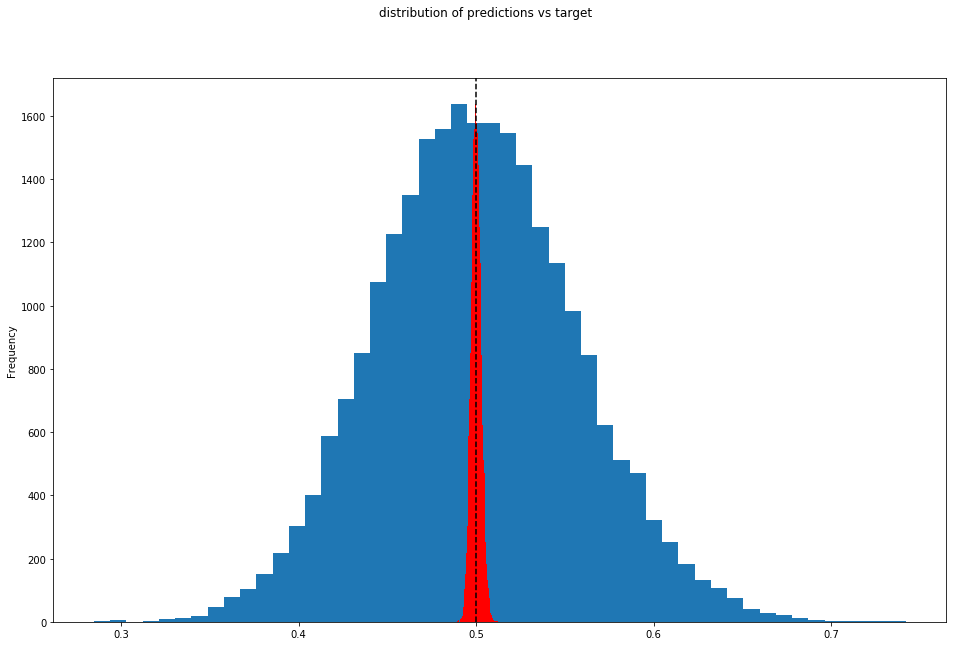

In [26]:
ax = ins['prob'].plot(kind='hist',subplots=True,sharex=False,sharey=True,title='distribution of predictions vs target', bins=50)
ax[0].axvline(.5, color='k', linestyle='--')
#ins['target'].plot(kind='hist', ax=ax[0], color='red', bins=50)

(((ins['prob']-.5)*.05)+.5).plot(kind='hist', ax=ax[0], color='red', bins=50); # strinkage around 50%?

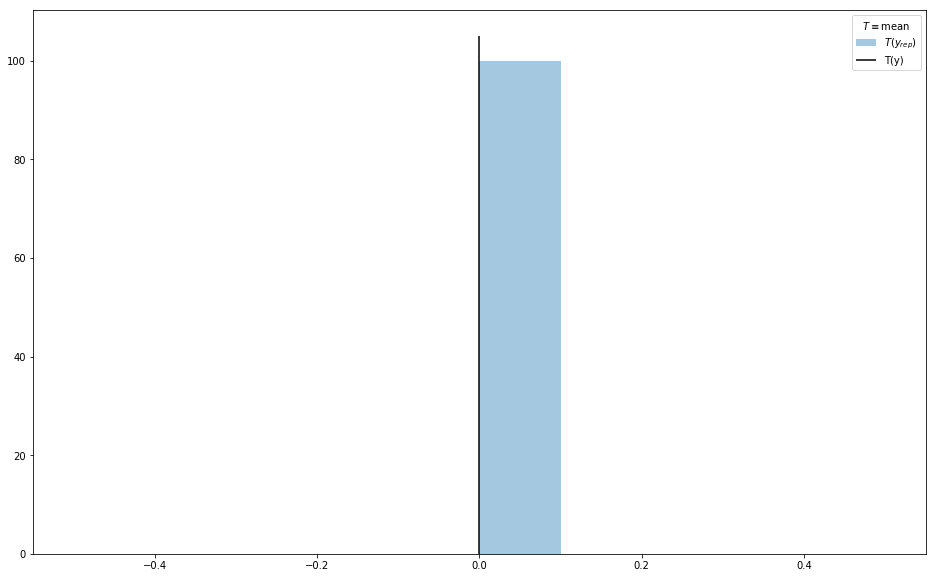

In [27]:
x_post = ed.copy(X, {w: qw, b: qb})

y_rep, y1 = ed.ppc(
    lambda xs, zs: tf.reduce_mean(tf.cast(xs[x_post], tf.float32)),
    data={x_post: X_data})

ed.ppc_stat_hist_plot(
    y1[0], y_rep, stat_name=r'$T \equiv$mean', bins=10)
plt.show()

In [28]:
ed.ppc(lambda xs, zs: tf.reduce_mean(tf.cast(xs[x_post], tf.float32)), data={x_post: X_data})

[array([  3.57112812e-10,   3.57112812e-10,   3.57112812e-10,
          3.57112812e-10,   3.57112812e-10,   3.57112812e-10,
          3.57112812e-10,   3.57112812e-10,   3.57112812e-10,
          3.57112812e-10,   3.57112812e-10,   3.57112812e-10,
          3.57112812e-10,   3.57112812e-10,   3.57112812e-10,
          3.57112812e-10,   3.57112812e-10,   3.57112812e-10,
          3.57112812e-10,   3.57112812e-10,   3.57112812e-10,
          3.57112812e-10,   3.57112812e-10,   3.57112812e-10,
          3.57112812e-10,   3.57112812e-10,   3.57112812e-10,
          3.57112812e-10,   3.57112812e-10,   3.57112812e-10,
          3.57112812e-10,   3.57112812e-10,   3.57112812e-10,
          3.57112812e-10,   3.57112812e-10,   3.57112812e-10,
          3.57112812e-10,   3.57112812e-10,   3.57112812e-10,
          3.57112812e-10,   3.57112812e-10,   3.57112812e-10,
          3.57112812e-10,   3.57112812e-10,   3.57112812e-10,
          3.57112812e-10,   3.57112812e-10,   3.57112812e-10,
        

In [29]:
def T(xs, zs):
    return tf.reduce_max(xs[y_post])

ppc_max = ed.ppc(T, data={X: X_data, y_post: y_data})

In [30]:
## correlation with target is approxmently mean of posterior distribution on parameter

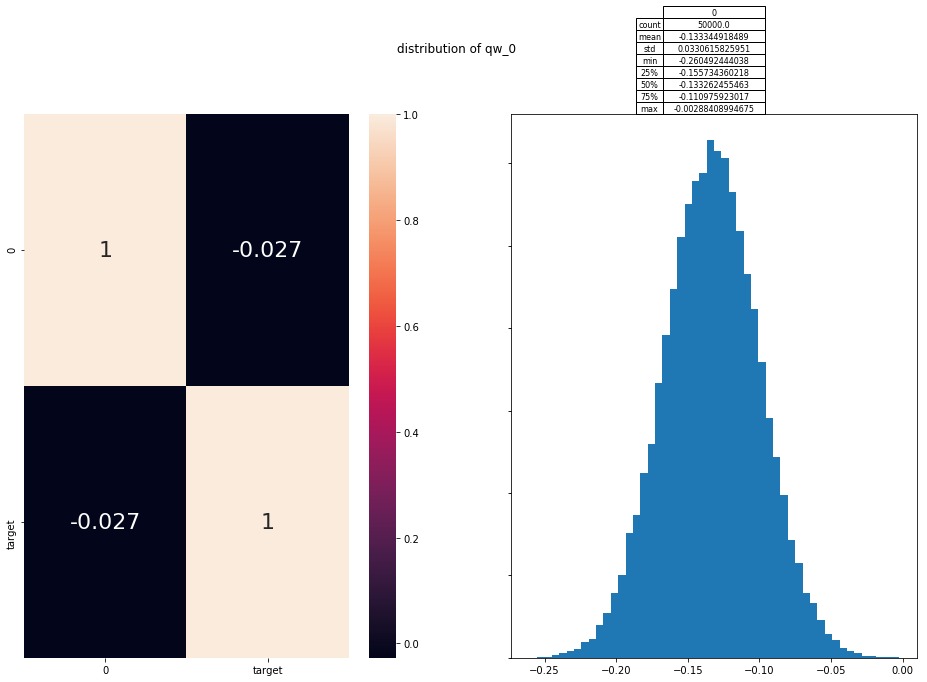

In [31]:
fig, axs = plt.subplots(1,2)


df = pd.DataFrame(X_data[:,0])
df['target'] = y_data
sns.heatmap(df.corr(), annot=True, ax=axs[0], annot_kws={'size':22})
dc = pd.Series(qw.sample(50000).eval()[:,0])
ax = dc.plot(kind='hist',subplots=True,sharex=False,sharey=True,title='distribution of qw_0', bins=50, ax=axs[1])

dcsummary = pd.DataFrame(dc.describe())
plt.table(cellText=dcsummary.values,colWidths = [0.25]*len(dcsummary.columns),
          rowLabels=dcsummary.index,
          colLabels=dcsummary.columns,
          cellLoc = 'center', rowLoc = 'center',
          loc='top');

In [32]:
dcsummary

,0
count,50000.000000
mean,-0.133345
std,0.033062
min,-0.260492
25%,-0.155734
50%,-0.133262
75%,-0.110976
max,-0.002884


In [33]:
## ppc is 1 since y_data.mean() > 1?

In [34]:
y_data.mean()

0.5

In [35]:
ppc_max

[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], dtype=int32),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])]

### Baseline Comparison (sklearn)

We compare our results againist sklearn's Naive Bayes (BernoulliNB) and Logistic Regression (LogisticRegression).

Note how BernoulliNB is somewhat predictive, though strictly the worse of our candidate models, all the while LogisticRegression does well on the accurate prediction but poorly on the out of sample logloss metric.

In [36]:
def get_skpreds(dat, shrink=False):
    preds = clf.predict_proba(dat)[:,1]
    if shrink:
        preds -= preds.mean()
        preds *= .3 #todo?
        preds += .5
    return preds

In [37]:
from sklearn.naive_bayes import BernoulliNB

print('NAIVE BAYES:')
clf = BernoulliNB()
clf.fit(X_data, y_data)
preds = get_skpreds(X_data)
eval_model(X_data, y_data, 'ins', preds)
preds = get_skpreds(X_test)
eval_model(X_test, y_test, 'oos', preds);

print('LOGISTIC REGRESSION:')
from sklearn import linear_model
#regularization_C = 1e3 #lower == more regularization
clf = linear_model.LogisticRegression()
clf.fit(X_data, y_data)
preds = get_skpreds(X_data)
eval_model(X_data, y_data, 'ins', preds)
preds = get_skpreds(X_test)
eval_model(X_test, y_test, 'oos', preds);

print('bayesian-forecast')
print('--------')
ins = eval_model(X_data, y_data, 'ins')
oos = eval_model(X_test, y_test, 'oos');

NAIVE BAYES:
ins 
------
acc: 0.533925428068
sk.logloss: 0.68949784753
ed.logloss (corrected): 0.689498
ed.logloss (current): 0.722479
regime1 (0.253) : 0.532008830022 0.690117127231
regime2 (0.252) : 0.530903328051 0.689142422587
regime3 (0.251) : 0.529355608592 0.690419165717
regime4 (0.242) : 0.543937892303 0.688289521737
consistency: 1.0

oos 
------
acc: 0.509349065093
sk.logloss: 0.694645291126
ed.logloss (corrected): 0.694646
ed.logloss (current): 0.723287
regime86 (0.609) : 0.510589394188 0.694829773501
regime87 (0.390) : 0.507416879795 0.694357904388
consistency: 0.0

LOGISTIC REGRESSION:
ins 
------
acc: 0.542606817091
sk.logloss: 0.687249823913
ed.logloss (corrected): 0.68725
ed.logloss (current): 0.721611
regime1 (0.253) : 0.539577420372 0.688006530847
regime2 (0.252) : 0.548177496038 0.686056126528
regime3 (0.251) : 0.532856006364 0.68899819069
regime4 (0.242) : 0.550049554014 0.685885747818
consistency: 1.0

oos 
------
acc: 0.515148485151
sk.logloss: 0.6938275114
ed.logl

,edward,sklearn
count,24996.000000,24996.000000
mean,0.499950,0.500000
std,0.055887,0.051113
min,0.284852,0.309448
25%,0.461787,0.464662
50%,0.498669,0.499281
75%,0.536914,0.534462
max,0.742080,0.693144


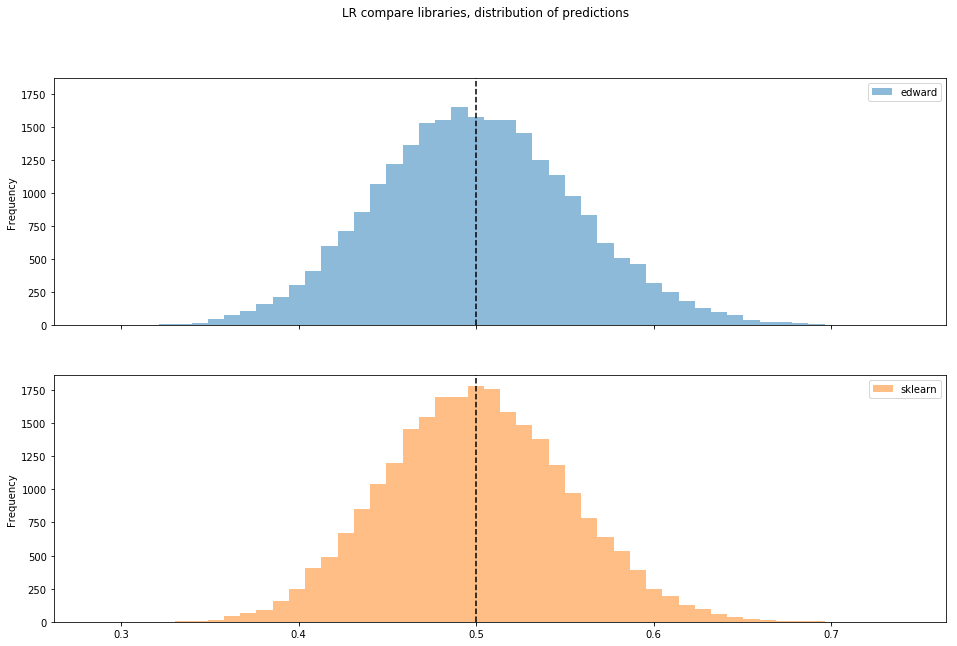

In [40]:
inspreds = pd.DataFrame(
    {
        'sklearn':get_skpreds(X_data),
        'edward':ins['prob']
    })

ax = inspreds.plot(alpha=.5,kind='hist',subplots=True,sharex=True,sharey=True,title='LR compare libraries, distribution of predictions', bins=50)
#.plot(kind='hist', alpha=.5, color='green', subplots=True,sharex=False,sharey=True,title='distribution of predictions vs target', bins=50)
ax[0].axvline(.5, color='k', linestyle='--')
ax[1].axvline(.5, color='k', linestyle='--');
inspreds.describe()

Note the subtle difference in OoS in consistency, accurary, and logloss: the edward bayesian probabilistic programming approach actually out performs the sklearn run. Of course at the risk of cherry picking, I'd suggest more empirical trials.

$$ D_{KL}[P(X) \, \Vert \, Q(X)] = \sum_{x \in X} P(x) \, \log \left( \frac{P(x)}{Q(x)} \right) $$

Lets try to explain why theoritically. Our inference technique used was KLqp (reverse KL), which we know makes candidate distribution q 'mode seeking' as opposed to 'mean seeking' in forward KL. Assuming the 'truth' P is a complex function, its not far fetch to think that our model in edward saught one of those modes for our posterior normal distribution of weights, qw.

See an excellent and intuitive write up on forward vs reverse KL divergence here: https://wiseodd.github.io/techblog/2016/12/21/forward-reverse-kl/

![alt text](https://wiseodd.github.io/img/2016-12-21-forward-reverse-kl/forward_kl_bad.png "mode seeking KL")

In [39]:
# # build posterior predictive after inference:
# # it is parameterized by a posterior sample
# x_post = ed.copy(x, {z: qz, beta: qbeta})

# # posterior predictive check
# # T is a user-defined function of data, T(data)
# T = lambda xs, zs: tf.reduce_mean(xs[x_post])
# ed.ppc(T, data={x_post: x_train})

# # in general T is a discrepancy function of the data (both response and
# # covariates) and latent variables, T(data, latent_vars)
# T = lambda xs, zs: tf.reduce_mean(zs[z])
# ed.ppc(T, data={y_post: y_train, x_ph: x_train},
#        latent_vars={z: qz, beta: qbeta})

# # prior predictive check
# # run ppc on original x
# ed.ppc(T, data={x: x_train})